<a href="https://colab.research.google.com/github/ryan-cqx/Coursera-Capstone-Project/blob/master/The_Battle_of_Neighbourhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project - The Battle of Neighborhoods**


This notebook contains my submission of the final assignment of the IBM Data Science Professional Certificate - Coursera

# **1. Introduction/ Business Problem**

**Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.**


Toronto is a city with a population of approximately 2,731,571 and it is the provincial capital of Ontario, Canada. It is a multi-cultural city is ethinically diverse. 


This analysis aims to provide tips and guidelines for tourist who are visiting the city. We will look into the crime rate, the neighbourhoods and the most frequented locations. 


It is known that there are many websites and apps that give advice to travellers however, they rarely mention about the crime rates and the safety of the location. Hence it is clear that there is a need to look into this area of safety. 

I have been a tourist in many countries and have struggled to find out how dangerous it is to go to certain tourist locations. 

# **2. Data**

**Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.**



**Data of the neighborhoods in Toronto will be extracted from:** https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M


**Data of incidents/crimes that occurred in Toronto:** http://data.torontopolice.on.ca/datasets?q=crime



We will scrap the data from the table on Wikipedia which contains the neighbourhood details, borough and postal codes. 

The geocoder API will be utilized to extract the data and obtain the coordinates of Toronto and the neighborhoods. This will create the main dataframe to be used.

The foursquare location API will be utilized to obtain the details of the venue and specific information about the neighborhoods. This will enable us to parse and process the data to construct a formatted table to display the results containing the information retrieved. 



## Import Libaries

In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import json # library to handle JSON files


#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import requests

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')

Libraries imported.


# **Define Foursquare credentials**

In [4]:
CLIENT_ID = 'D25WQNG0EPZKVYGZLSFMYNPRRV5ZI5AP5QAH1DPT5SJE5FRA' # your Foursquare ID
CLIENT_SECRET = 'HD2HLCGSNTYMXVUII35SCMXWU22FZHBDSWP0D22X0C3NZRRS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30

print('done')


done


# **Analyzing incidents and the crime rate in Toronto**


**Source:** http://data.torontopolice.on.ca/datasets?q=crime


This Dataset includes all Major Crime Indicators (MCI) from 2014 - 2018 in Toronto. However, it has been filtered to only include 2018 values for the purpose of this analysis.

The Major Crime Indicators categories are Assault, Break and Enter,  Auto Theft, Robbery and Theft Over (Excludes Sexual Assaults). 

In [5]:
df_incidents = pd.read_csv('https://raw.githubusercontent.com/ryan-cqx/Coursera-Capstone-Project/master/MCI_2014_to_2018.csv')

print('Dataset downloaded and read into a pandas dataframe!')
df_incidents.head()


Dataset downloaded and read into a pandas dataframe!


,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.349564,43.751801,16023,GO-2018173076,2018-01-28T04:07:00.000Z,2018-01-28T04:07:00.000Z,Other,1460,100,Assault Peace Officer,2018,January,28,28,Sunday,4,2018.0,January,28.0,28.0,Sunday,4,Assault,D33,42,Banbury-Don Mills (42),43.751801,-79.349564,14017
1,-79.446579,43.781750,15811,GO-2018110752,2018-01-18T11:00:00.000Z,2018-01-18T15:46:00.000Z,House,2120,220,B&E W'Intent,2018,January,18,18,Thursday,15,2018.0,January,18.0,18.0,Thursday,11,Break and Enter,D32,35,Westminster-Branson (35),43.781750,-79.446579,14021
2,-79.474754,43.786186,16024,GO-2018177085,2018-01-28T19:50:00.000Z,2018-01-28T20:54:00.000Z,Commercial,1610,180,Robbery - Swarming,2018,January,28,28,Sunday,20,2018.0,January,28.0,28.0,Sunday,19,Robbery,D32,27,York University Heights (27),43.786186,-79.474754,14022
3,-79.283165,43.793003,15812,GO-201867724,2018-01-11T19:40:00.000Z,2018-01-11T19:50:00.000Z,House,2120,200,B&E,2018,January,11,11,Thursday,19,2018.0,January,11.0,11.0,Thursday,19,Break and Enter,D42,128,Agincourt South-Malvern West (128),43.793003,-79.283165,14026
4,-79.392059,43.645374,16025,GO-2018253179,2018-02-09T14:12:00.000Z,2018-02-09T14:12:00.000Z,Outside,1420,100,Assault With Weapon,2018,February,9,40,Friday,14,2018.0,February,9.0,40.0,Friday,14,Assault,D52,77,Waterfront Communities-The Island (77),43.645374,-79.392059,14027


In [6]:
df_incidents.shape

(36303, 29)

Create a bar chart of the incidents that occur throughout the day. This enables us to visualize how the frequency of crimes occur each day.

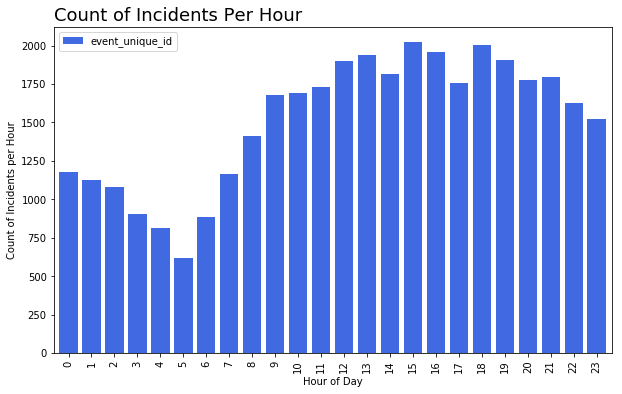

In [7]:
df_incidents.groupby('reportedhour').count().plot(y = 'event_unique_id', 
                                                      kind = 'bar',figsize=(10, 6),
                                                      width=0.8,
                                                      color = '#4169E1'
                                                     )


plt.xlabel('Hour of Day')
plt.ylabel('Count of Incidents per Hour')
plt.title('Count of Incidents Per Hour', loc='left', fontsize=18)


plt.show()

As shown above we can see that there is a significant increase in the occurence of crime after 5pm. Hence, this serves as a reminder to tourist to be more cautious when they are travelling in the night.

**TOP 5 incidents that commonly occur**

We would like to analyze the type of crimes that occur the most.

In [8]:
# Find the top 5 Incidents that occurred
top_crimes = df_incidents[['MCI', 'event_unique_id']].groupby(
    ['MCI'], as_index=False).count().sort_values(
    'event_unique_id', ascending=False).head(5)
top_crimes.head()

,MCI,event_unique_id
0,Assault,19327
2,Break and Enter,7551
1,Auto Theft,4674
3,Robbery,3527
4,Theft Over,1224


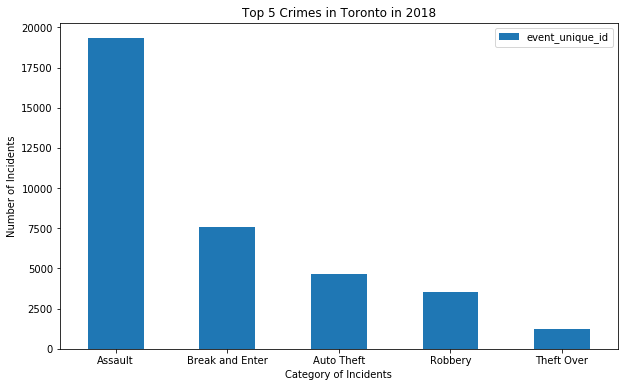

In [9]:
# Plot the top 5 Incidents
top_crimes.plot(kind='bar', figsize=(10, 6),x='MCI', rot=0)

plt.xlabel('Category of Incidents') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Top 5 Crimes in Toronto in 2018') # add title to the plot



plt.show()

As shown above, Assault is the most common occuring crime. This could be attributed to the frequented night scene locations in Downtown Toronto. We will look into this in the section below.

# **Visualize the crimes in Toronto on the map** **bold text**

In [0]:
# Retrieve Json file for San Fransisco
!wget --quiet https://opendata.arcgis.com/datasets/98f7dde610b54b9081dfca80be453ac9_0.geojson?where=reportedyear%20%3E%3D%202018%20AND%20reportedyear%20%3C%3D%202018 -O toronto_geo.json 

In [11]:
# get the first 100 crimes in the df_incidents dataframe
limit = 100
df_incidents = df_incidents.iloc[0:limit, :]
df_incidents.shape

(100, 29)

In [12]:
import folium.plugins as plugins
# Toronto latitude and longitude values
latitude = 43.653963
longitude = -79.387207

# let's start again with a clean copy of the map of San Francisco
toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(toronto_map)
 
# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_incidents.Y, df_incidents.X, df_incidents.MCI):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
toronto_map

It can be observed that there is a large concentration of crimes occuring in downtown Toronto. As Downtown Toronto has many points of interest and is frquented by Tourist, we will focus our analysis in that area.

# **Neighbourhoods in Toronto**

In [13]:
df_Toronto = pd.read_csv('https://raw.githubusercontent.com/ryan-cqx/Coursera-Capstone-Project/master/df_toronto_final.csv')

df_Toronto.head()

,Unnamed: 0,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**Lets visualize the neighbourhoods in Toronto**

The city of Toronto is made up of 140 neighbourhoods. Toronto is known to be made up of different ethnic groups and has many cultures.


The boundaries for these neighbourhoods were developed using the following criteria:

originally based on an Urban Development Services Residential Communities map, based on planning areas in former municipalities, and existing Public Health neighbourhood planning areas;
no neighbourhood be comprised of a single census tract;
minimum neighbourhood population of at least 7,000 to 10,000;
where census tracts were combined to meet criteria 2 or 3 above, they were joined with the most similar adjacent area according to the percentage of the population living in low income households;
respecting existing boundaries such as service boundaries of community agencies, natural boundaries (rivers), and man-made boundaries (streets, highways, etc.);
maintaining neighbourhood areas small enough for service organizations to combine them to fit within their service area; and
the final number of neighbourhood areas be manageable for the purposes of data presentation and reporting.

Source: https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/

In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_Toronto['Latitude'], df_Toronto['Longitude'], df_Toronto['Borough'], df_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Looking at Downtown Toronto**

As stated previously we will be looking at the tourist locations and most frequented areas in Downtown Toronto

In [15]:
DT_Toronto_data = df_Toronto[df_Toronto['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
DT_Toronto_data.head()

,Unnamed: 0,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,51,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,53,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
4,54,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [35]:
# create map of Toronto using latitude and longitude values
map_DT_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(DT_Toronto_data['Latitude'], DT_Toronto_data['Longitude'], DT_Toronto_data['Borough'], DT_Toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DT_toronto)  
    
map_DT_toronto

In [0]:
# Function to generate a list of venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Create new dataFrame of venues in Downtown Toronto**

In [18]:
DT_Toronto_venues = getNearbyVenues(names=DT_Toronto_data['Neighbourhood'],
                                   latitudes=DT_Toronto_data['Latitude'],
                                   longitudes=DT_Toronto_data['Longitude']
                                  )



Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie


# **Analyze the neighbourhoods in Downtown Toronto**


We would like to find out the most frequented locations in each neighbourhood

In [19]:
# one hot encoding
DT_Toronto_onehot = pd.get_dummies(DT_Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
DT_Toronto_onehot['Neighbourhood'] = DT_Toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [DT_Toronto_onehot.columns[-1]] + list(DT_Toronto_onehot.columns[:-1])
DT_Toronto_onehot = DT_Toronto_onehot[fixed_columns]

DT_Toronto_onehot.head()

,Neighbourhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,...,Pet Store,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
# let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category
DT_Toronto_grouped = DT_Toronto_onehot.groupby('Neighbourhood').mean().reset_index()


In [21]:
num_top_venues = 5

for hood in DT_Toronto_grouped['Neighbourhood']:
    print("***"+hood+"***")
    temp = DT_Toronto_grouped[DT_Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','frequency']
    temp = temp.iloc[1:]
    temp['frequency'] = temp['frequency'].astype(float)
    temp = temp.round({'frequency': 2})
    print(temp.sort_values('frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

***Adelaide, King, Richmond***
              venue  frequency
0        Steakhouse       0.10
1              Café       0.10
2  Asian Restaurant       0.07
3             Hotel       0.07
4         Gastropub       0.03


***Berczy Park***
                venue  frequency
0                Café       0.07
1  Seafood Restaurant       0.07
2      Farmers Market       0.07
3        Cocktail Bar       0.07
4            Beer Bar       0.07


***CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara***
              venue  frequency
0    Airport Lounge       0.14
1  Airport Terminal       0.14
2           Airport       0.07
3          Boutique       0.07
4               Bar       0.07


***Cabbagetown, St. James Town***
                venue  frequency
0  Italian Restaurant       0.07
1          Restaurant       0.07
2              Bakery       0.07
3                Café       0.07
4         Coffee Shop       0.07


***Central Bay Street***
   

Lets generate the Top venues in downtown Toronto

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = DT_Toronto_grouped['Neighbourhood']

for ind in np.arange(DT_Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DT_Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Café,Asian Restaurant,Hotel,Seafood Restaurant
1,Berczy Park,Farmers Market,Café,Seafood Restaurant,Beer Bar,Cocktail Bar
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Harbor / Marina,Sculpture Garden,Airport Food Court
3,"Cabbagetown, St. James Town",Coffee Shop,Café,Italian Restaurant,Bakery,Restaurant
4,Central Bay Street,Coffee Shop,Bubble Tea Shop,Spa,Italian Restaurant,Café


# **Clustering neighbourhoods in Toronto**

We will utilze K-Means to cluster the neighbourhoods into 5 clusters.

k-means is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from unlabeled data.

In [24]:
# set number of clusters
kclusters = 5

DT_Toronto_grouped_clustering = DT_Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DT_Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 3, 3, 0, 1, 0, 3, 3], dtype=int32)

In [0]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

DT_Toronto_merged = DT_Toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
DT_Toronto_merged = DT_Toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')



In [26]:
DT_Toronto_merged.head() # check the last columns!

,Unnamed: 0,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2,Park,Playground,Trail,Building,Yoga Studio
1,51,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,3,Coffee Shop,Café,Italian Restaurant,Bakery,Restaurant
2,52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Gay Bar,Burger Joint,Ramen Restaurant,Diner,Bookstore
3,53,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,3,Coffee Shop,Park,Bakery,Breakfast Spot,Mexican Restaurant
4,54,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Café,Clothing Store,Burger Joint,Restaurant,Hotel


In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DT_Toronto_merged['Latitude'], DT_Toronto_merged['Longitude'], DT_Toronto_merged['Neighbourhood'], DT_Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
DT_Toronto_merged.loc[DT_Toronto_merged['Cluster Labels'] == 0, DT_Toronto_merged.columns[[1] + list(range(5, DT_Toronto_merged.shape[1]))]]

,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,M4Y,-79.383160,0,Gay Bar,Burger Joint,Ramen Restaurant,Diner,Bookstore
4,M5B,-79.378937,0,Café,Clothing Store,Burger Joint,Restaurant,Hotel
6,M5E,-79.373306,0,Farmers Market,Café,Seafood Restaurant,Beer Bar,Cocktail Bar
8,M5H,-79.384568,0,Steakhouse,Café,Asian Restaurant,Hotel,Seafood Restaurant
9,M5J,-79.381752,0,Park,Café,Plaza,Hotel,Performing Arts Venue
13,M5T,-79.400049,0,Café,Vietnamese Restaurant,Caribbean Restaurant,Mexican Restaurant,Comfort Food Restaurant
15,M5W,-79.374846,0,Café,Cocktail Bar,Seafood Restaurant,Beer Bar,Farmers Market


In [29]:
DT_Toronto_merged.loc[DT_Toronto_merged['Cluster Labels'] == 1, DT_Toronto_merged.columns[[1] + list(range(5, DT_Toronto_merged.shape[1]))]]

,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,M6G,-79.422564,1,Grocery Store,Café,Park,Coffee Shop,Diner


In [30]:
DT_Toronto_merged.loc[DT_Toronto_merged['Cluster Labels'] == 2, DT_Toronto_merged.columns[[1] + list(range(5, DT_Toronto_merged.shape[1]))]]

,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4W,-79.377529,2,Park,Playground,Trail,Building,Yoga Studio


In [31]:
DT_Toronto_merged.loc[DT_Toronto_merged['Cluster Labels'] == 3, DT_Toronto_merged.columns[[1] + list(range(5, DT_Toronto_merged.shape[1]))]]

,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,M4X,-79.367675,3,Coffee Shop,Café,Italian Restaurant,Bakery,Restaurant
3,M5A,-79.360636,3,Coffee Shop,Park,Bakery,Breakfast Spot,Mexican Restaurant
5,M5C,-79.375418,3,Coffee Shop,Italian Restaurant,Gastropub,Restaurant,Hotel
7,M5G,-79.387383,3,Coffee Shop,Bubble Tea Shop,Spa,Italian Restaurant,Café
10,M5K,-79.381576,3,Coffee Shop,Restaurant,Café,Deli / Bodega,Hotel Bar
11,M5L,-79.379817,3,Café,Coffee Shop,Restaurant,Deli / Bodega,Gastropub
12,M5S,-79.400049,3,Café,Italian Restaurant,Restaurant,Bookstore,Bar
16,M5X,-79.382280,3,Café,Coffee Shop,Deli / Bodega,Restaurant,Steakhouse


In [32]:
DT_Toronto_merged.loc[DT_Toronto_merged['Cluster Labels'] == 4, DT_Toronto_merged.columns[[1] + list(range(5, DT_Toronto_merged.shape[1]))]]

,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,M5V,-79.39442,4,Airport Lounge,Airport Terminal,Harbor / Marina,Sculpture Garden,Airport Food Court


We have used k-means to partition the neighbourhoods as specifed in the algorithm.

The neighbourhood in each cluster are similar to each other in terms of the features included in the dataset, in this case based on their most frequented venues. 

For example, cluster 3 can be observed to be the most frequented location for cafes. This information can be useful for tourist when they are visiting the area.

# **Recommendations**

It would be recommended to adjust the parameters according to the points of interest and run the cluster analysis again. This would be well suited based on different needs.

# **Discussion and Conclusion**


We have analyzed the top crimes that have occured in Toronto in 2018. This gives the user advice on the type of incidents that occur and the time at which they should be more cautious. 

Furthermore, we looked at how the neighbourhood of Downtown Toronto was clustered based on their most frequented venues. This provides the user with suggestion on what can be found and is popular with the people who frequent the location. 


In conclusion, this aims to provide tourist with tips and guides on where and when to stay cautious when travelling. 

